In [ ]:
!pip install pandas networkx python-louvain matplotlib

In [1]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

In [2]:
df = pd.read_csv('Airports2.csv')

# 4. Airline Network Partitioning (Q4)

#### **The Disconnection Problem**

In graph theory, the disconnection problem involves partitioning a graph into two or more disjoint subgraphs by removing the minimal set of edges.  

In this case the graph represents the airline's flight network where the nodes are the airports and the links between them are the flights.

The following function implement the partion in this way: 

 - **Identify Minimum Edge Cut**  
    The smallest set of edges to remove is identified using graph theory algorithms, specifically minimum_edge_cut in NetworkX.

 - **Graph Partitioning**  
    Once the edges are removed, the graph splits into two connected components, representing the two independent partitions of the network.
 - **Visualization**  
    The original network is visualized to show the complete structure.
    The resulting subgraphs are visualized, highlighting the two disconnected partitions.

In [3]:
def partitioning(data_frame):
    """
    Disconnection Problem - Partition a flight network in two separate graph removing the minimum number of flights between airports.

    Parameters:
    -----------
    data_frame : DataFrame
        The data frame containing flight network data.

    Returns:
    --------
    list: the list of flight removed to disconnect the graph.
    """
    df = data_frame

    # Validate required columns
    required_columns = ['Origin_airport', 'Destination_airport']

    # Create a Graph from the flight network
    G = nx.Graph()

    # Add edges to the graph based on the flight data
    for _, row in df.iterrows():
        origin_airport = row['Origin_airport']
        destination_airport = row['Destination_airport']
        G.add_edge(origin_airport, destination_airport)

    # Find the minimum edge cut
    edge_cut = list(nx.minimum_edge_cut(G))
    
    # Remove the edges to disconnect the graph
    G.remove_edges_from(edge_cut)
    
    # Identify the two resulting subgraphs
    subgraphs = list(nx.connected_components(G))
    if len(subgraphs) != 2:
        raise ValueError("Graph is not separable into exactly two partitions with a single cut.")
    
    # Extract subgraph nodes
    subgraph1_nodes = subgraphs[0]
    subgraph2_nodes = subgraphs[1]
    
    # Visualization of the original graph
    plt.figure(figsize=(12, 6))
    plt.title("Original Flight Network")
    nx.draw_networkx(G, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.show()
    
    # Visualization of the disconnected subgraphs
    plt.figure(figsize=(12, 6))
    plt.title("Disconnected Flight Network")
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=subgraph1_nodes, node_color="red", label="Partition 1")
    nx.draw_networkx_nodes(G, pos, nodelist=subgraph2_nodes, node_color="blue", label="Partition 2")
    nx.draw_networkx_edges(G, pos, edge_color="gray")
    plt.legend()
    plt.show()

    return edge_cut

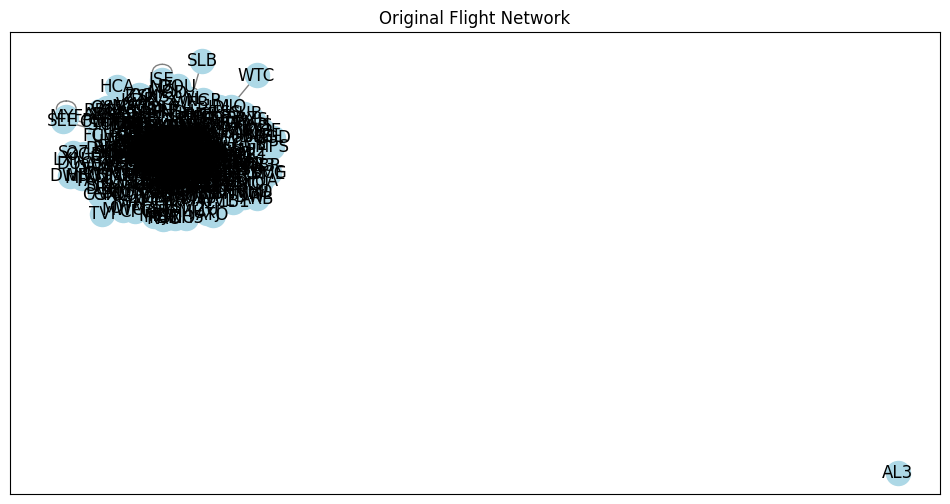

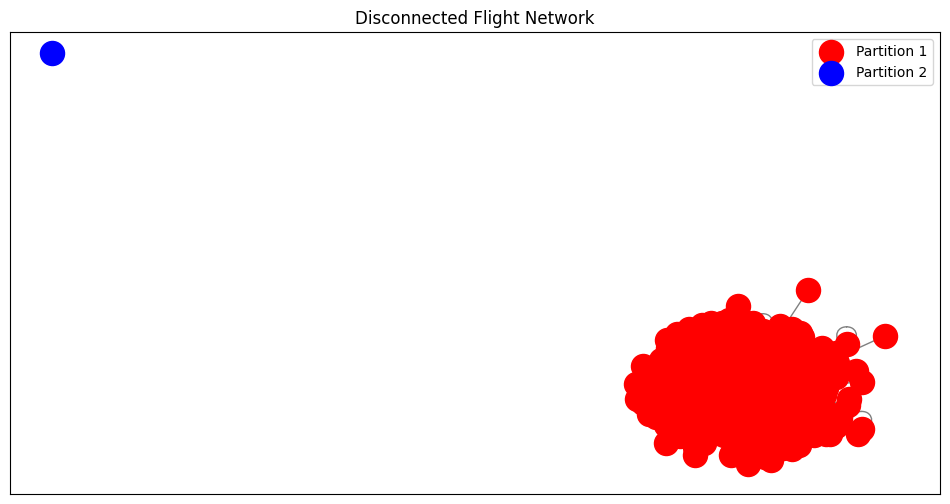

Removed edges to disconnect the graph: [('ILG', 'AL3')]


In [4]:
removed_edges = partitioning(df)
print("Removed edges to disconnect the graph:", removed_edges)

# 5. Finding and Extracting Communities (Q5)


### **What is a Community?**

A community in a network is a subset of nodes (vertices) that are more tightly connected to each other compared to their connections to nodes outside the subset. For example:
- In a social network, communities could represent groups of friends who interact frequently.
- In a flight network (our case), communities could represent clusters of airports with high intra-cluster flight traffic.

Community detection methods locate communities based on network structure, such as strongly connected groupings of nodes; however, they often ignore node properties.  
Nodes of similar types form a community in a network. Intra-community edges are the edges that connect the nodes in a community.

### **Application in a Flight Network**

In a flight network:
- **Nodes:** Represent airports (cities).
- **Edges:** Represent direct flight connections between airports.
- **Communities:** Represent clusters of cities with frequent or significant interconnections, often corresponding to geographical regions or airline hubs.

Airlines can use community detection to:
1. **Optimize Routes:** Identify regions with dense traffic for efficient routing.
2. **Resource Allocation:** Focus on underserved regions for market expansion.
3. **Operational Planning:** Consolidate flights in low-demand areas to improve profitability.



For an implementation guide and further insights, refer to resources like [this article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/).

#### **Load the dataset** 

### **Create the *detect_flight_network_communities* Function**

 - It select only the Origin_city and Destination_city columns  
 - Create an undirected graphand add the edges based on flights  
 - Apply community detection using the **community_louvian** method  
 - Get the community list  

After that we decided to plot the results using an interactive visualization (created using Plotly package), the cities in the same community have the same color.  
As requested we print the number of communities, the cities in each community and if the two cities given in input belong to the same community.


**The `community_louvain` method based on the *Louvain algorithm* maximize a metric called *modularity*.**  
The modularity measures the density of connections within communities compared to connections between communities. 

1. **Phase 1 - Local Optimization**:
   - Each node starts as its own community.
   - Nodes are iteratively moved to neighboring communities if doing so increases modularity.
   
2. **Phase 2 - Aggregation**:
   - Once no single-node moves can improve modularity further, communities are aggregated into "super-nodes."
   - The process is repeated on this aggregated network.

3. **Stopping Condition**:
   - The algorithm stops when no modularity improvement is possible, and the partitioning stabilizes.

The community_louvian algorithm method is 

- **Efficient** scaling well with large networks (e.g., millions of nodes).  
- It optimizes **modularity**to detect community .

In [10]:
def detect_flight_network_communities(data_frame, c1=None, c2=None):
    """
    Detect communities in a flight network and optionally check community membership for specific cities.

    Parameters:
    -----------
    data_frame : DataFrame
        The data frame containing flight network data.
    c1 : str, optional
        First city to check for community membership.
    c2 : str, optional
        Second city to check for community membership.

    Returns:
    --------
    dict: A dictionary containing community detection results.
    """
    df = data_frame

    # Validate required columns
    required_columns = ['Origin_city', 'Destination_city']
    if not all(col in df.columns for col in required_columns):
        print("Error: Required columns 'Origin_city' and 'Destination_city' not found in the DataFrame.")
        return None

    # Create a Graph from the flight network
    G = nx.Graph()

    # Add edges to the graph based on the flight data
    for _, row in df.iterrows():
        origin_city = row['Origin_city']
        destination_city = row['Destination_city']
        G.add_edge(origin_city, destination_city)

    # Apply community detection using the Louvain method
    partition = community_louvain.best_partition(G)

    # Get the communities (groups of cities) from the partition
    communities = {}
    for city, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(city)

    # Generate positions for nodes using a spring layout
    pos = nx.spring_layout(G, seed=42)  # Ensures reproducibility

    # Create edges for the plot
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # None separates individual edges
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        name='Edges'
    )

    # Create nodes for the plot
    node_x = []
    node_y = []
    node_color = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(partition[node])  # Color by community
        node_text.append(node)  # Add city names to hover text

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='Rainbow',
            size=10,
            color=node_color,
            colorbar=dict(
                thickness=15,
                title='Community ID',
                xanchor='left',
                titleside='right'
            )
        ),
        name='Nodes'
    )

    # Create the figure with the graph
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title="<b>Flight Network Communities</b>",
                        showlegend=True,
                        hovermode='closest',
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False),
                        width=2000,
                        height=1100
                    ))

    # Show the plot
    fig.show()

    # Check community membership for specific cities
    same_community = None
    if c1 and c2:
        if c1 in partition and c2 in partition:
            same_community = partition[c1] == partition[c2]
        else:
            print(f"Warning: One or both cities ({c1}, {c2}) not found in the network.")

    # Prepare results
    results = {
        'total_communities': len(communities),
        'communities': communities,
        'community_membership_check': {
            'city1': c1,
            'city2': c2,
            'in_same_community': same_community
        }
    }

    return results

# Example usage (assuming a DataFrame `df` is already defined)
# results = detect_flight_network_communities(df, c1='Seattle, WA', c2='Portland, OR')


### **Check for Seattle, WA and Portland, OR**

In [11]:
# Detect communities
results = detect_flight_network_communities(
    df, 
    c1='Seattle, WA',
    c2='Portland, OR'
)

# Print community details
print(f"\nTotal number of communities: {results['total_communities']}")
for comm_id, cities in results['communities'].items():
    print(f"Community {comm_id}: {cities}")

# Print community membership check
membership_check = results['community_membership_check']
print(f"\nDo {membership_check['city1']} and {membership_check['city2']} belong to the same community? {membership_check['in_same_community']}")



Total number of communities: 4
Community 3: ['Manhattan, KS', 'Ames, IA', 'Wichita, KS', 'Duluth, MN', 'Oklahoma City, OK', 'Dubuque, IA', 'Omaha, NE', 'Peoria, IL', 'Wausau, WI', 'Topeka, KS', 'North Platte, NE', 'Aberdeen, SD', 'Brainerd, MN', 'Bismarck, ND', 'Liberal, KS', 'Madison, WI', 'Lincoln, NE', 'Waterloo, IA', 'Rockford, IL', 'Green Bay, WI', 'La Crosse, WI', 'Milwaukee, WI', 'Fort Dodge, IA', 'Des Moines, IA', 'Eau Claire, WI', 'Mason City, IA', 'Kansas City, MO', 'Grand Forks, ND', 'Minneapolis, MN', 'Springfield, MO', 'Scottsbluff, NE', 'Sioux Falls, SD', 'Grand Island, NE', 'Cedar Rapids, IA', 'Sioux City, IA', 'Garden City, KS', 'Springfield, IL', 'Decatur, IL', 'Chicago, IL', 'Pierre, SD', 'Minot, ND', 'Rochester, MN', 'St. Louis, MO', 'Evansville, IN', 'Champaign, IL', 'Bloomington, IL', 'Detroit, MI', 'Salina, KS', 'Quincy, IL', 'Dodge City, KS', 'Madisonville, KY', 'Terre Haute, IN', 'Great Bend, KS', 'Hays, KS', 'Kearney, NE', 'Burlington, IA', 'Joplin, MO', 'Fort